In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display, HTML, IFrame
from wordcloud import WordCloud
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [2]:
#Reading Crime data
df_crime = pd.read_csv(r"crime.csv",encoding='windows-1254')
df_offense_codes = pd.read_csv(r"offense_codes.csv",encoding='windows-1254')
print(df_crime.shape, df_offense_codes.shape)

(319073, 11) (576, 3)


In [32]:
%%time

#The offense codes file indicates which offense code corresponds to each specific crime type
data = df_crime.merge(df_offense_codes, right_on = 'CODE', left_on = 'OFFENSE_CODE')
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
data['YEAR'] = data['OCCURRED_ON_DATE'].dt.year
data['MONTH'] = data['OCCURRED_ON_DATE'].dt.strftime('%b')
data['HOUR'] = data['OCCURRED_ON_DATE'].dt.hour
data['DAY'] = data['OCCURRED_ON_DATE'].dt.day_name()
data.DAY = pd.Categorical(data.DAY, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)
data.drop_duplicates(inplace = True)
data.dropna(subset=['INCIDENT_NUMBER', 'OFFENSE_CODE', 'DISTRICT'], how='any', inplace=True)
data['STREET'].fillna('Unknown Streets', inplace=True)
data['SHOOTING'].fillna('N', inplace=True)

Wall time: 56.4 s


In [4]:
def distribution_plot(df, column_name, ax, num):    
    #Calculate the percentage of each category
    if num == 'all':
        category_percentages = (df[column_name].value_counts(normalize=True)*100)
    else:
        category_percentages = (df[column_name].value_counts(normalize=True)*100).head(num)        
    #Create a bar chart
    category_percentages.plot(kind='bar', ax=ax)    
    ax.set_xlabel(column_name)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Distribution of crime by {column_name} (Percentage)')
    ax.set_xticklabels(category_percentages.index, rotation=45, ha='right')

def pie_chart(df, column_name, ax, num):
    #Calculate the percentage of each category
    if num == 'all':
        category_percentages = (df[column_name].value_counts(normalize=True) * 100)
    else:
        category_percentages = (df[column_name].value_counts(normalize=True) * 100).head(num)        
    #Create a pie chart
    category_percentages.plot(kind='pie', autopct='%1.1f%%', ax=ax)    
    ax.set_ylabel('')
    ax.set_title(f'Distribution of {column_name} (Percentage)')

In [5]:
def find_most_least_incidents(data_count_shoot, shooting=False):    
    data_count = data_count_shoot.groupby(['YEAR', 'STREET'])['INCIDENT_NUMBER'].sum().reset_index()
    #Find the street with the most incidents
    most_incidents_street = data_count.loc[data_count.groupby('YEAR')
                                           ['INCIDENT_NUMBER'].idxmax()][['YEAR', 'STREET', 'INCIDENT_NUMBER']]
    most_incidents_street.rename(columns={'INCIDENT_NUMBER': 'Most Incidents'}, inplace=True)
    most_incidents_street.set_index('YEAR', inplace=True)     
    #Find the street with the least incidents
    least_incidents_street = data_count.loc[data_count.groupby('YEAR')
                                            ['INCIDENT_NUMBER'].idxmin()][['YEAR', 'STREET', 'INCIDENT_NUMBER']]
    least_incidents_street.rename(columns={'INCIDENT_NUMBER': 'Least Incidents'}, inplace=True)
    least_incidents_street.set_index('YEAR', inplace=True)      
    if shooting == True:
        #Find the street with the most shootings
        shootings_data = data_count_shoot[data_count_shoot['SHOOTING'] == 'Y']
        most_shootings_street = shootings_data.loc[shootings_data.groupby('YEAR')
                                            ['INCIDENT_NUMBER'].idxmax()][['YEAR', 'STREET', 'INCIDENT_NUMBER']]
        most_shootings_street.rename(columns={'INCIDENT_NUMBER': 'Most Shootings'}, inplace=True)
        most_shootings_street.set_index('YEAR', inplace=True)  
        return most_incidents_street, least_incidents_street, most_shootings_street
    else:
        return most_incidents_street, least_incidents_street

In [6]:
data_count_shoot = data.groupby(['YEAR', 'STREET', 'SHOOTING'])['INCIDENT_NUMBER'].count().reset_index()
most_incidents, least_incidents, most_shootings = find_most_least_incidents(data_count_shoot, shooting=True)
print("Street names with the most incidents across the years: \n", most_incidents)
print("\nStreet names with the least incidents across the years: \n", least_incidents)
print("\nStreet names with the most shootings across the years: \n", most_shootings)

Street names with the most incidents across the years: 
                STREET  Most Incidents
YEAR                                 
2015    WASHINGTON ST            3457
2016  Unknown Streets            6833
2017    WASHINGTON ST            5936
2018    WASHINGTON ST            4049

Street names with the least incidents across the years: 
                STREET  Least Incidents
YEAR                                  
2015    13 DIXWELL ST                1
2016   BLUE HILL AVE                 1
2017        0 BURRELL                1
2018   BLUE HILL AVE                 1

Street names with the most shootings across the years: 
                STREET  Most Shootings
YEAR                                 
2015        DUDLEY ST              18
2016    BLUE HILL AVE              33
2017    WASHINGTON ST              29
2018  Unknown Streets              14


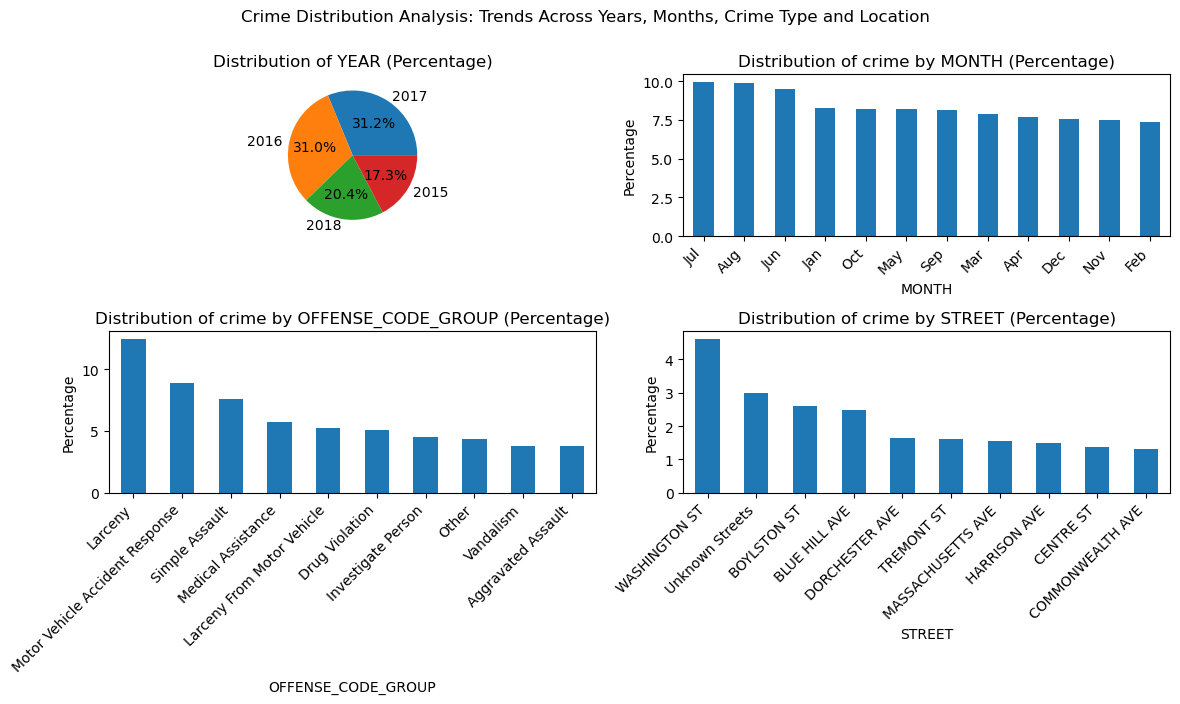

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
pie_chart(data, 'YEAR',  axes[0, 0], num = 'all')
distribution_plot(data, 'MONTH', axes[0, 1], num = 'all')
distribution_plot(data, 'OFFENSE_CODE_GROUP',  axes[1, 0], num = 10)
distribution_plot(data, 'STREET', axes[1, 1], num = 10)
plt.suptitle('Crime Distribution Analysis: Trends Across Years, Months, Crime Type and Location', fontsize=12, y=1)
plt.tight_layout()
plt.show()

C:\Users\rohit\AppData\Local\Temp\ipykernel_17580\1944642193.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels(), size=14)
C:\Users\rohit\AppData\Local\Temp\ipykernel_17580\1944642193.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(axes[1].get_yticklabels(), size=14)


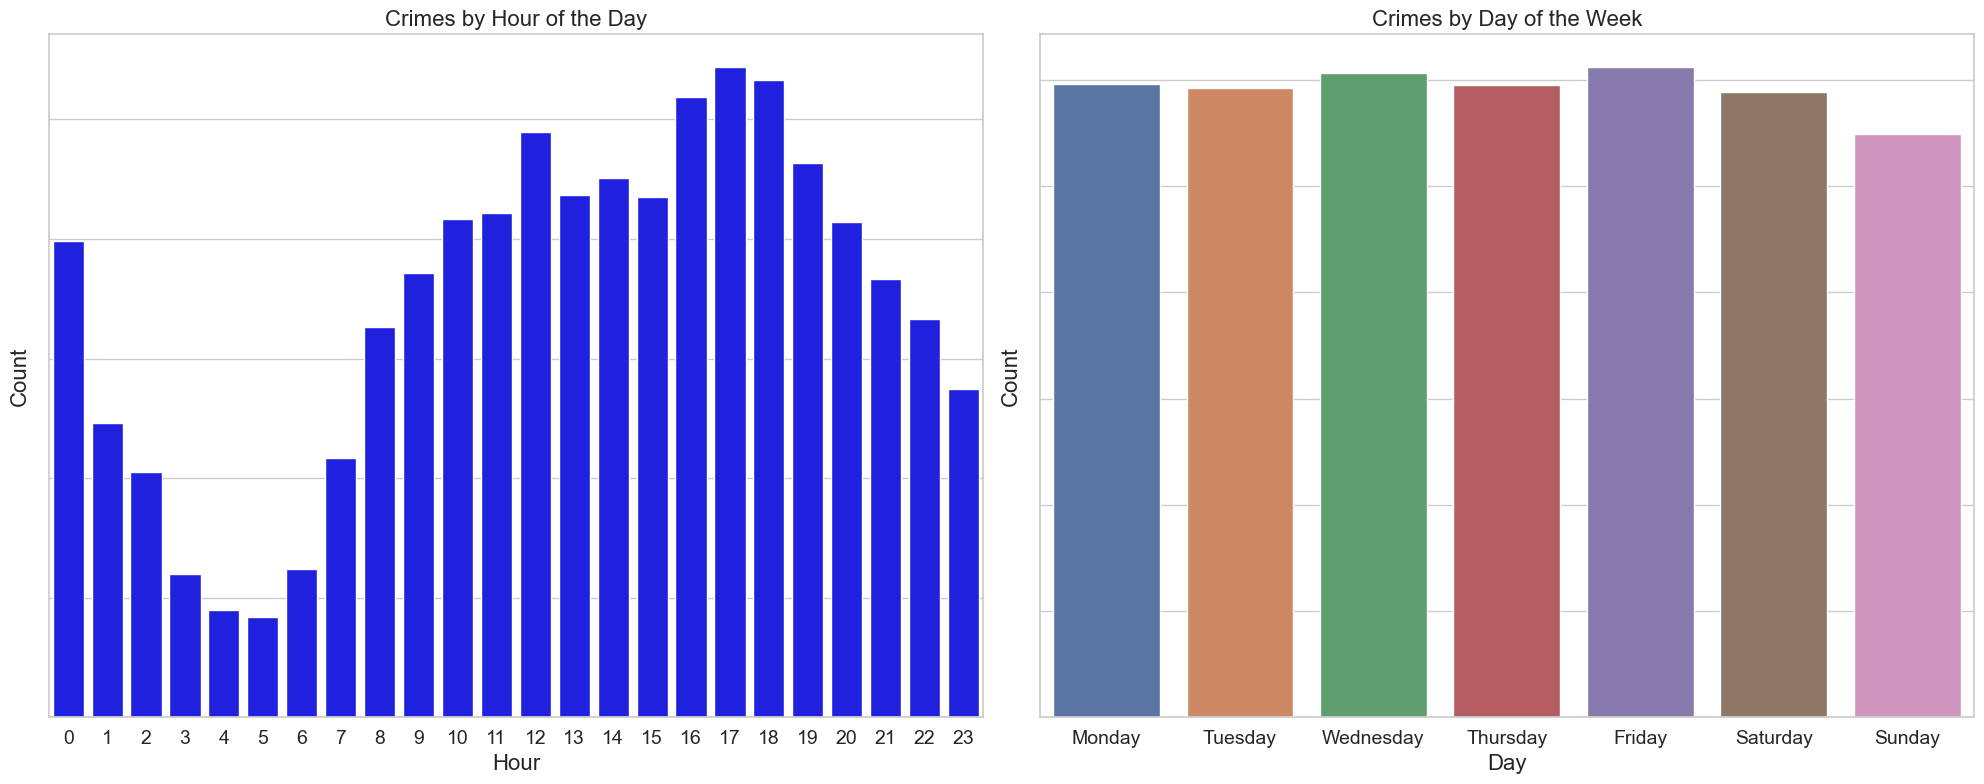

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Crimes by hour of the day
sns.countplot(x='HOUR',
              color='blue',
              data=data,
              ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), size=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), size=14)
axes[0].set_xlabel('Hour', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].set_title('Crimes by Hour of the Day', fontsize=16)

# Plot 2: Crimes by day of the week
sns.countplot(x='DAY',
              data=data,
              ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), size=14)
axes[1].set_yticklabels(axes[1].get_yticklabels(), size=14)
axes[1].set_xlabel('Day', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_title('Crimes by Day of the Week', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


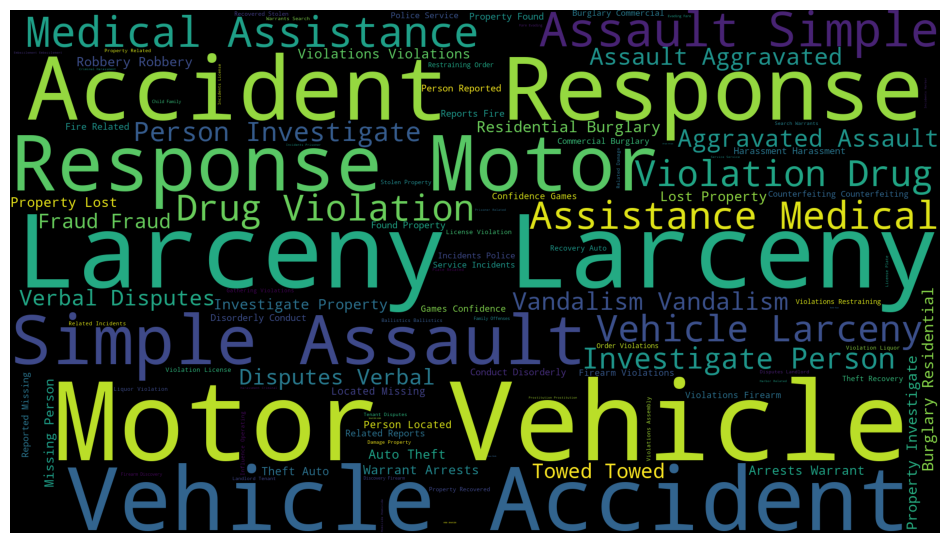

Wall time: 9.47 s


In [11]:
plt.figure(figsize=(12,7))
wordcloud = WordCloud(
                          background_color='black',
                          width=1920,
                          height=1080
                         ).generate(" ".join(data.OFFENSE_CODE_GROUP))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [38]:
data_non_null = data.dropna(subset=['Lat','Long'], how='any')

# Create a Folium Map centered around the mean of the coordinates
map_center = [data_non_null['Lat'].mean(), data_non_null['Long'].mean()]
my_map = folium.Map(location=map_center, zoom_start=13)

# Create a HeatMap layer using the latitude and longitude data
heat_data = [[point['Lat'], point['Long']] for index, point in data_non_null.iterrows()]
HeatMap(heat_data).add_to(my_map)

# Save the map as an HTML file or display it
map_file = "heatmap.html"
my_map.save(map_file)

# Display the map in the Jupyter Notebook using an IFrame
IFrame(map_file, width=700, height=500)
